# Director Analysis
Use the IMDb data to uncover the film directors' career path
In here, I use the IMDb set that includes millions films' information which has already been cleaned for use. The data clean steps will be post later.

Firstly, load dataset:

In [71]:
#Modules used in the data
import pandas as pd
import numpy as np
from   scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import time
import psycopg2
from tqdm import tqdm
pd.set_option('display.max_columns', 20)
pd.set_option('precision',2)


In [72]:
def tempfileread():
    df = pd.read_csv('/Users/xintongli/PycharmProjects/Project/Film Data Analysis/Data_temp.csv',
                     index_col = 0,low_memory=False)
    df_name = pd.read_csv('/Users/xintongli/PycharmProjects/Project/Film Data Analysis/SQL_name.csv',
                          index_col = 0)
    #Depend on specific which table to analyze
    df_flexible = pd.read_csv('/Users/xintongli/PycharmProjects/Project/Film Data Analysis/SQL_exp.csv',
                          index_col = 0)
    summary = pd.read_csv('/Users/xintongli/PycharmProjects/Project/Film Data Analysis/SQL_summary.csv',
                          index_col = 0)
    dflist = pd.read_csv('/Users/xintongli/PycharmProjects/Project/Film Data Analysis/List_temp')
    return df, df_name, df_flexible, summary, dflist

df      = tempfileread()[0].sort_index()
df_name = tempfileread()[1].sort_index()
year_a  = tempfileread()[2].sort_index()
summary = tempfileread()[3].sort_index()

df.columns = df.columns.str.lower()

df: data sort by film title

df_name: uses the film directors as entry, described each film directors' profile
* nconst (string) - alphanumeric unique identifier of the name/person
* primaryName (string)– name by which the person is most often credited
* birthYear
* deathYear
* age

year_a: year analysis. Analyze year related data grouped by directors; excluded director without the bith year and age greater than 110
* startyearmin - the first film release year
* startyearmax - the last film release year
* toprate - the top rated film
* numvotes - popularity of the directors. Total number of votes
* numberall - total film realeased before the directors past away
* birthyear - directors' birthyear
* age - directors' age
* topyearmin - first top rated film release year
* topyearmax - last top rated film release year
* topyearavg - average age to produce the top rated film
* count - number of top rated film
* startyearlen - the career length. The length of the first film and the last film release year
* topyearlen - topyearmax - topyearmin
* topagemin - age when shoots the first top rated film. Topyearmin - birthyear
* topagemax - age when shoots the last top rated film. Topyearmax - birthyear
    
summary: general information about data
* numberall - numbers of directed film
* runtimeminutes - average film running times of each director
* averagerating - arithmetic average of rating
* numvotes - total number of people who vote for film, indicating the popularity of the film/director

Take a look at general information

In [73]:
print(summary['numberall'].describe())

print('Percentil of direct 1 film: ' +'{}'.format(stats.percentileofscore(summary['numberall'].to_list(),2)))

print('Percentil of direct 5 film: ' +'{}'.format(stats.percentileofscore(summary['numberall'].to_list(),5)))


count    111380.00
mean          2.56
std           4.98
min           1.00
25%           1.00
50%           1.00
75%           2.00
max         202.00
Name: numberall, dtype: float64
Percentil of direct 1 film: 70.35015263063387
Percentil of direct 5 film: 90.27697970910397


There are 111380 film directors in the summary. 70.4% of them direct for only 1 film, and 10% directs more than 5 movies.

In [74]:
df[['runtimeminutes', 'averagerating', 'numvotes']].describe()

,runtimeminutes,averagerating,numvotes
count,226742.00,252540.00,2.53e+05
mean,94.29,6.14,3.35e+03
std,118.95,1.32,3.19e+04
min,1.00,1.00,5.00e+00
25%,81.00,5.40,1.40e+01
50%,91.00,6.30,5.00e+01
75%,103.00,7.00,2.67e+02
max,51420.00,10.00,2.30e+06


In [75]:
print('The longest film is: ' + '{}'.format(df['runtimeminutes'].max()) + ', number votes: ' + 
      '{}'.format(df['numvotes'][df['runtimeminutes'] == df['runtimeminutes'].max()].iloc[0]))

print('Percentage of lower than 100 votes: ' +'{}'.format(stats.percentileofscore(df['numvotes'].to_list(),100)))

The longest film is: 51420.0, number votes: 49.0
Percentage of lower than 100 votes: 61.653401441355825


Among 200 thousands films, the length of film is quite stable, with the average film length around 1.5 hours. Interestingly, there is an outlier -- the 51420 minutes(35 days) film, and 49 users vote for it. The rating of IMDb ranged from 1 to 10, with the mean score 6.14, and 75% of rates is lower than 7. It seems that get high scores is not easy in IMDb. The popularity are different from movie to movie. 61.7% of films have fewer than 100 people votes.

These are the overview of the film data. Those statistics indicates that a large part of films are produced without attracting enough attention from the public. Films are made for different reason, as the 35-days-long documentary definitely does not targeted on the same group as commercial film does.

## Director's Career Length and Rating
Secondly, let us take look into details of the relation between the directos' career length and film's rating.

In [76]:
print('Average career length: ' + '{}'.format(year_a['startyearlen'].mean()))

print('Average career length with multiple piece: ' + 
      '{}'.format(year_a['startyearlen'][year_a['numberall']>1].mean()))

Average career length: 8.858376249621326
Average career length with multiple piece: 14.767688500580778


Directors' average career life is 8.6 years. However, as previous part shows, 70% of film directors only produce one 1 films, and their career length shortens to zero, when the career length is estimated with the length between film' release year. To exclude those "outliers", the average career length increases to 14.8 years.

Average top rating 6.685501363223266
Average rating 6.241451607110791
Mode of top rating 7.0
Mode of rating 6.8


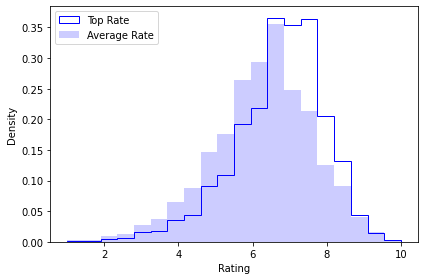

In [78]:
#Director's top rated film
fig, ax = plt.subplots()
ax.hist(year_a['toprate'],
        density = True, histtype = 'step', bins=20, label = 'Top Rate', color = 'Blue')
ax.hist(summary['averagerating'],
        density = True, alpha =0.2, bins=20, label = 'Average Rate', color = 'Blue')
ax.set_xlabel('Rating')
ax.set_ylabel('Density')
plt.tight_layout()
ax.legend(loc='upper left')
print(('Average top rating ' + '{}'.format(year_a['toprate'].mean())))
print(('Average rating ' + '{}'.format(summary['averagerating'].mean())))

print(('Mode of top rating ' + '{}'.format(year_a['toprate'].mode()[0])))
print(('Mode of rating ' + '{}'.format(summary['averagerating'].mode()[0])))

When plot the average rating and the top average rating, the density of the top rate shift ot the left with higher grades. The mean rate shift from 6.2 to 6.7, which is 5% increase in rate, and most common rating moves to 7.0 compared with 6.8.

Even with the highest rate of director's film, the rating still remains between rate 6 to 7, no siginificant change to higher score.

In [97]:
#Dirctor's Golden Age of Creation
print('Golen Age of all film Directors\' age:')
print(year_a[['topagemin', 'topagemax']].mean())


print('Golen Age of multiple films Directors\' age:')
print(year_a[['topagemin', 'topagemax']][year_a['numberall']>1].mean())
print(year_a['topyearlen'].describe())

Golen Age of all film Directors' age:
topagemin    40.91
topagemax    41.28
dtype: float64
Golen Age of multiple films Directors' age:
topagemin    41.57
topagemax    42.19
dtype: float64
count    33010.00
mean         0.37
std          2.31
min          0.00
25%          0.00
50%          0.00
75%          0.00
max         50.00
Name: topyearlen, dtype: float64


The golden age of creation is around 40 to 41.